In [61]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit import transpile

from qiskit_aer import AerSimulator

In [62]:
from qiskit.quantum_info import Statevector, Operator, DensityMatrix

# Parameters
h_A = 1; h_B = 0.01; k = 0.393; 
h_C = np.sqrt(h_B**2 + 4*k**2) 

# Basis
ket_0 = np.array([[1],[0]])
ket_1 = np.array([[0],[1]])
ket_00 = np.kron(ket_0,ket_0)
ket_11 = np.kron(ket_1,ket_1)
ket_000 = np.kron(ket_00,ket_0)

# Operators
I = Operator.from_label('III').to_matrix()
Z_A = Operator.from_label('IIZ').to_matrix(); Z_B = Operator.from_label('IZI').to_matrix(); Z_C = Operator.from_label('ZII').to_matrix()
X_AB = Operator.from_label('IXX').to_matrix(); X_A = Operator.from_label('IIX').to_matrix()
Y_B = Operator.from_label('IYI').to_matrix(); Y_C = Operator.from_label('YII').to_matrix()

# Ground state
theta = np.arctan(np.sqrt((h_A/(2*k) + h_B/(2*k))**2+1)-(h_A/(2*k) + h_B/(2*k)))

qet_g = np.cos(theta)*ket_00 - np.sin(theta)*ket_11
ket_g = np.kron(ket_0,qet_g)
state_g = Statevector(ket_g)
display('Ground State:', state_g.draw('latex'))

# Hamiltonians
alpha = 2*k/(np.sqrt((h_A + h_B)**2+4*k**2) + h_A + h_B)

H_A = -h_A * Z_A - h_A *(alpha**2-1)/(alpha**2+1) * I
H_B = -h_B * Z_B - h_B*(alpha**2-1)/(alpha**2+1) * I
H_C = -h_C * Z_C + h_C * I
V = 2*k * X_AB + 4*k*alpha/(alpha**2+1) * I

# Define angle phi
phi = np.arctan(np.sqrt((h_B/(2*k))**2+1)-h_B/(2*k)) - theta

# Define operations
def P_A(mi):
    """Measurement of qubit A"""
    return 1/2 * (I + mi * X_A)

def Ry_B(mi):
    """Rotation around Y axis for qubit B"""
    return np.cos(phi) * I - 1j*mi*np.sin(phi) * Y_B

def Ry_C(mi):
    """Rotation around Y axis for qubit C"""
    return np.cos(phi) * I - 1j*mi*np.sin(phi) * Y_C

def Ry_pi():
    """Rotation of pi around Y axis for qubit C"""
    return np.cos(np.pi/2) * I - 1j*np.sin(np.pi/2) * Y_C

# Final State Density Matrix
P_QET = np.zeros((8, 8), dtype=complex)
for mi in [-1, 1]:
    P_QET = P_QET + Ry_C(-mi) @ Ry_B(-mi) @  Ry_C(mi) @ Ry_pi() @P_A(mi) @ (ket_g@ket_g.conj().T) @ P_A(mi) @ Ry_pi().conj().T @ Ry_C(mi).conj().T  @ Ry_B(-mi).conj().T @ Ry_C(-mi).conj().T
display('Final State Density Matrix:', Operator(P_QET).draw('latex'))

# Energies
E_Ha = np.trace(P_QET@H_A).real
E_Hb = np.trace(P_QET@H_B).real
E_Hc = np.trace(P_QET@H_C).real
E_V = np.trace(P_QET@V).real
E_A = np.trace(P_QET@(H_A+V)).real
E_B = np.trace(P_QET@(H_B+V)).real 

# Print results
print(f"""
Ground State Energies:
<H_A> = {ket_g.T@H_A@ket_g}
<H_B> = {ket_g.T@H_B@ket_g}
<V> = {ket_g.T@V@ket_g}
            
Final Energies:
H_A = {E_Ha},
H_B = {E_Hb},
H_C = {E_Hc},
V = {E_V},
E_A = {E_A},
E_B = {E_B}
""")

'Ground State:'

<IPython.core.display.Latex object>

'Final State Density Matrix:'

<IPython.core.display.Latex object>


Ground State Energies:
<H_A> = [[-8.32667268e-17+0.j]]
<H_B> = [[-1.51788304e-18+0.j]]
<V> = [[0.+0.j]]
            
Final Energies:
H_A = 0.7891838926010616,
H_B = 0.007764622758458546,
H_C = 1.5721272213151196,
V = -0.30320901615994295,
E_A = 0.48597487644111864,
E_B = -0.2954443934014844



In [63]:
def qet(h_A,h_B,k):
    qc = QuantumCircuit(3)

    # Prepare ground state
    theta = np.arctan(np.sqrt((h_A/(2*k) + h_B/(2*k))**2+1)-(h_A/(2*k) + h_B/(2*k)))
                  
    qc.ry(-2*theta,0)
    qc.cx(0,1)
    qc.barrier()

    # Alice's projective measurement
    qc.h(0)
    qc.barrier()

    # Charlie prepare qubit C
    phi = np.arctan(np.sqrt((h_B/(2*k))**2+1)-h_B/(2*k)) - theta

    qc.cry(np.pi - 2*phi,0,2)

    qc.x(0)
    qc.cry(np.pi + 2*phi,0,2)
    qc.x(0)
    qc.barrier()

    #Bob's conditional operation
    qc.cry(2*phi,0,1)
    qc.cry(2*phi,0,2)
    
    qc.x(0)
    qc.cry(-2*phi,0,1)
    qc.cry(-2*phi,0,2)
    qc.x(0)

    return qc

In [64]:
# Sampler
simulator = AerSimulator()

n_shots = 5000

# Sem nada
qc = qet(h_A,h_B,k)
qc.measure_all()
S_job_1 = simulator.run(qc,shots=n_shots)

# H(0)
qc = qet(h_A,h_B,k)
qc.h(0)
qc.measure_all()
S_job_2 = simulator.run(qc,shots=n_shots)

# H(1)
qc = qet(h_A,h_B,k)
qc.h(1)
qc.measure_all()
S_job_3 = simulator.run(qc,shots=n_shots)

# H(0) e H(1)
qc = qet(h_A,h_B,k)
qc.h(0)
qc.h(1)
qc.measure_all()
S_job_4 = simulator.run(qc,shots=n_shots)

In [65]:
# Estimator
from qiskit_aer.primitives import EstimatorV2 
from qiskit.quantum_info import SparsePauliOp 

simulator = AerSimulator()
estimator = EstimatorV2()

observables = [SparsePauliOp('IIZ',h_A), SparsePauliOp('IZI',h_B), SparsePauliOp('IXX',2*k)]

# Sem nada
qc = qet(h_A,h_B,k)
E_job_1_1 = estimator.run([(qc, observables[0])])
E_job_1_2 = estimator.run([(qc, observables[1])])
E_job_1_3 = estimator.run([(qc, observables[2])])

# medida especial X_A
X_A = SparsePauliOp('IIX',2*k)
E_job_X_A = estimator.run([(qc, X_A)])

# H(0)
qc = qet(h_A,h_B,k)
qc.h(0)
E_job_2_1 = estimator.run([(qc, observables[0])])
E_job_2_2 = estimator.run([(qc, observables[1])])
E_job_2_3 = estimator.run([(qc, observables[2])])

# H(1)
qc = qet(h_A,h_B,k)
qc.h(1)
E_job_3_1 = estimator.run([(qc, observables[0])])
E_job_3_2 = estimator.run([(qc, observables[1])])
E_job_3_3 = estimator.run([(qc, observables[2])])

# H(0) e H(1)
qc = qet(h_A,h_B,k)
qc.h(0)
qc.h(1)
E_job_4_1 = estimator.run([(qc, observables[0])])
E_job_4_2 = estimator.run([(qc, observables[1])])
E_job_4_3 = estimator.run([(qc, observables[2])])

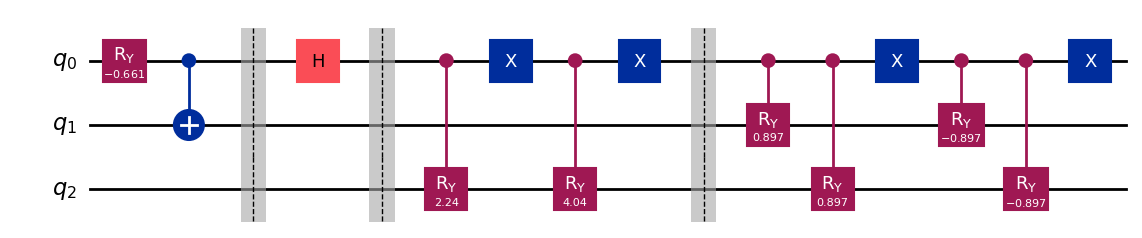

In [66]:
qc = qet(h_A,h_B,k)
qc.draw('mpl')

In [67]:
p = DensityMatrix(Statevector(ket_000).evolve(qc.to_instruction()))
display(p.draw('latex'))

<IPython.core.display.Latex object>

In [68]:
# Extract results
counts = S_job_1.result().get_counts()
exp_value_A = E_job_1_1.result()[0].data.evs
exp_value_B = E_job_1_2.result()[0].data.evs
exp_value_V = E_job_1_3.result()[0].data.evs

exp_X_A = E_job_X_A.result()[0].data.evs

# Energies
alpha = 2*k/(np.sqrt((h_A + h_B)**2+4*k**2) + h_A + h_B)
f_i = (alpha**2-1)/(alpha**2+1)
ene_A = -h_A*f_i
ene_B = -h_B*f_i
ene_C = h_C
ene_V = 4*k*alpha/(alpha**2+1)

est_A = exp_value_A + ene_A
est_B = exp_value_B + ene_B
est_V = exp_value_V + ene_V

est_X_A = exp_X_A + ene_A

# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        ene_A += -h_A*(-1)**int(bit_string[0])*count/n_shots
        ene_B += -h_B*(-1)**int(bit_string[1])*count/n_shots
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

# Print results
print(f'A = {E_Ha}, S = {ene_A}, E = {est_A}')
print(f'B = {E_Hb}, S = {ene_B}, E = {est_B}')
print(f'V = {E_V}, S = {ene_V}, E = {est_V}')

print(f'X_A = {est_X_A}')

A = 0.7891838926010616, S = 0.7963838926010616, E = 0.7891838926010617
B = 0.007764622758458546, S = 0.008119838926010616, E = 0.008019055093562688
V = -0.30320901615994295, S = 0.49939057833006495, E = 0.482727378330065
X_A = 0.7991830833706545


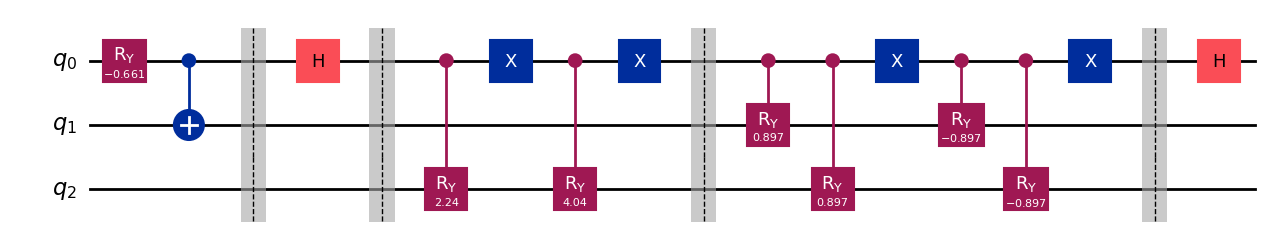

In [69]:
qc = qet(h_A,h_B,k)
qc.barrier()
qc.h(0)
qc.draw('mpl')

In [70]:
phi = DensityMatrix(Statevector(ket_000).evolve(qc.to_instruction()))
display(phi.draw('latex'))

<IPython.core.display.Latex object>

In [71]:
# Extract results
counts = S_job_2.result().get_counts()
exp_value_A = E_job_2_1.result()[0].data.evs
exp_value_B = E_job_2_2.result()[0].data.evs
exp_value_V = E_job_2_3.result()[0].data.evs

# Energies
alpha = 2*k/(np.sqrt((h_A + h_B)**2+4*k**2) + h_A + h_B)
f_i = (alpha**2-1)/(alpha**2+1)
ene_A = -h_A*f_i
ene_B = -h_B*f_i
ene_C = h_C
ene_V = 4*k*alpha/(alpha**2+1)

est_A = exp_value_A + ene_A
est_B = exp_value_B + ene_B
est_V = exp_value_V + ene_V


# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        ene_A += -h_A*(-1)**int(bit_string[0])*count/n_shots
        ene_B += -h_B*(-1)**int(bit_string[1])*count/n_shots
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

# Print results
print(f'A = {E_Ha}, S = {ene_A}, E = {est_A}')
print(f'B = {E_Hb}, S = {ene_B}, E = {est_B}')
print(f'V = {E_V}, S = {ene_V}, E = {est_V}')

A = 0.7891838926010616, S = 0.7655838926010616, E = 0.8019055093562687
B = 0.007764622758458546, S = 0.007655838926010617, E = 0.008019055093562688
V = -0.30320901615994295, S = 1.268727378330065, E = -0.303209016159943


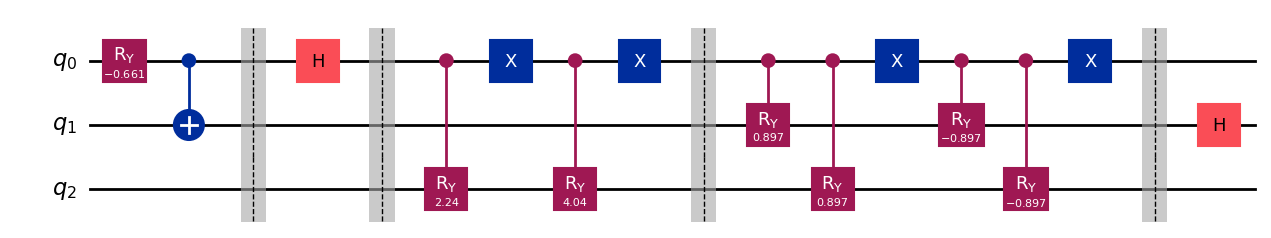

In [72]:
qc = qet(h_A,h_B,k)
qc.barrier()
qc.h(1)
qc.draw('mpl')

In [73]:
phi = DensityMatrix(Statevector(ket_000).evolve(qc.to_instruction()))
display(phi.draw('latex'))

<IPython.core.display.Latex object>

In [74]:
# Extract results
counts = S_job_3.result().get_counts()
exp_value_A = E_job_3_1.result()[0].data.evs
exp_value_B = E_job_3_2.result()[0].data.evs
exp_value_V = E_job_3_3.result()[0].data.evs

# Energies
alpha = 2*k/(np.sqrt((h_A + h_B)**2+4*k**2) + h_A + h_B)
f_i = (alpha**2-1)/(alpha**2+1)
ene_A = -h_A*f_i
ene_B = -h_B*f_i
ene_C = h_C
ene_V = 4*k*alpha/(alpha**2+1)

est_A = exp_value_A + ene_A
est_B = exp_value_B + ene_B
est_V = exp_value_V + ene_V


# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        ene_A += -h_A*(-1)**int(bit_string[0])*count/n_shots
        ene_B += -h_B*(-1)**int(bit_string[1])*count/n_shots
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

# Print results
print(f'A = {E_Ha}, S = {ene_A}, E = {est_A}')
print(f'B = {E_Hb}, S = {ene_B}, E = {est_B}')
print(f'V = {E_V}, S = {ene_V}, E = {est_V}')

A = 0.7891838926010616, S = 0.7787838926010617, E = 0.7891838926010617
B = 0.007764622758458546, S = 0.007995838926010617, E = 0.007891838926010617
V = -0.30320901615994295, S = -0.30327262166993507, E = 1.268727378330065


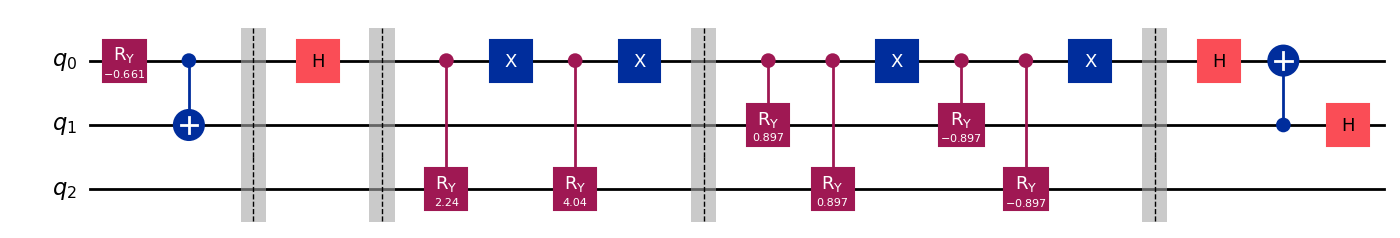

In [ ]:
qc = qet(h_A,h_B,k)
qc.barrier()
qc.h(0)
qc.h(1)
qc.draw('mpl')

In [156]:
phi = DensityMatrix(Statevector(ket_000).evolve(qc.to_instruction()))
display(phi.draw('latex'))

<IPython.core.display.Latex object>

In [82]:
# Extract results
counts = S_job_4.result().get_counts()
exp_value_A = E_job_4_1.result()[0].data.evs
exp_value_B = E_job_4_2.result()[0].data.evs
exp_value_V = E_job_4_3.result()[0].data.evs

# Energies
alpha = 2*k/(np.sqrt((h_A + h_B)**2+4*k**2) + h_A + h_B)
f_i = (alpha**2-1)/(alpha**2+1)
ene_A = -h_A*f_i
ene_B = -h_B*f_i
ene_C = h_C
ene_V = 4*k*alpha/(alpha**2+1)

est_A = exp_value_A + ene_A
est_B = exp_value_B + ene_B
est_V = exp_value_V + ene_V


# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        ene_A += -h_A*(-1)**int(bit_string[0])*count/n_shots
        ene_B += -h_B*(-1)**int(bit_string[1])*count/n_shots
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

# Print results
print(f'A = {E_Ha}, S = {ene_A}, E = {est_A}')
print(f'B = {E_Hb}, S = {ene_B}, E = {est_B}')
print(f'V = {E_V}, S = {ene_V}, E = {est_V}')

A = 0.7891838926010616, S = 0.7879838926010617, E = 0.8019055093562687
B = 0.007764622758458546, S = 0.007839838926010617, E = 0.007891838926010617
V = -0.30320901615994295, S = 0.47895457833006505, E = 0.4827273783300649
